# EM502 Lab 04 - E/17/371

Consider the problem minimize $f(x_1,x_2) = (1 − x_1)^2 + \frac{(1 − x_2)^2 + (−x_1^2 + 2x_2)^2}{2}$,  
having a gradient $∇f(x) = ([[−2x_1(−x_1^2 + 2x_2) + 2x_1−2], [−2x_1^2 + 6x_2 − 2]])$.


The optiamal point for this problem is given by $x∗ = (1.21,0.824)$
The function and the gradient is defined below.

In [ ]:
import numpy as np

f = lambda x: ((1 - x[0,:] )**2) + ((1 - x[1,:] )**2) + 0.5*((2*x[1,:] - x[0,:]**2)**2)
grad_f = lambda x: np.array([[2*x[0,:]*(x[0,:]**2 - 2*x[1,:]) + 2*x[0,:] - 2], 
                             [-2*x[0,:]**2 + 6*x[1,:] - 2]])

The function can be visualised with a contour map

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

X1,X2 = np.meshgrid(np.linspace(-3,3,40),np.linspace(-2,5,40))
X = np.vstack((X1.reshape([1,-1]),X2.reshape([1,-1]))) # flatten grids side-by-side
Z = f(X)
Z_grad = grad_f(X)

We will choose a starting point $x_0 = (−1.0, 2.0)$
This gives a steepest descent direction $d_0 = −∇(f(x_0)) = [−2, −8]^T$

Plot the function as contours, the initial point $x_0$, the true minimum $x∗$, the gradient vector $∇f(x_k)$ and the steepest descent direction $−∇f(x_k)$ below.

In [ ]:
x0 = np.array([-1,2])
grad_f0 = grad_f(x0[:,None]).squeeze()
d0 = -grad_f0
x_opt = [1.2134116627622296, 0.8241226211091329]

origin = np.array([x0]*2).T # origin point
vectors = np.array([grad_f0, -grad_f0])

fig, ax = plt.subplots(figsize=(7,6))
# plot
ax.contourf(X1, X2, Z.reshape(X1.shape),cmap=cm.coolwarm,levels=25,zorder=-1)
Q = ax.quiver(*origin, vectors[0:1,0], vectors[0:1,1], color=['r',], scale=50, zorder=1)
ax.quiverkey(Q, 0.1, 0.2, 2, r"$\nabla f(\mathbf{x}_0)$", labelpos='S', coordinates='axes')
Q = ax.quiver(*origin, vectors[1:2,0], vectors[1:2,1], color=['b'], scale=50, zorder=1)
ax.quiverkey(Q, 0.1, 0.1, 2, r"$\mathbf{d}_k = -\nabla f(\mathbf{x}_0)$", labelpos='S', coordinates='axes')
ax.plot([x0[0],x0[0] + 10*d0[0]], [x0[1],x0[1] + 10*d0[1]], color="k", label="line search", linewidth=0.5, linestyle="--",zorder=2)
ax.scatter([x_opt[0],], [x_opt[1],], marker="o", color="g", edgecolors="k", linestyle="None",label="$\mathbf{x}^*$",zorder=3)
ax.scatter([x0[0],], [x0[1],], marker="o", color="m", edgecolors="k", linestyle="None",label="$\mathbf{x}_0$",zorder=3)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.axis('equal')
ax.set_xlim((-3,3))
ax.set_ylim((-1,3))
ax.legend()
fig.canvas.draw()

We will see how the function changes its value along the search direction dk  
$ϕ(α)=f(x_k+1)=f(x_k+αd_k)$

We will look at the derivative (Please refer class notes)  
$ϕ′(α)=f′(x_k+αd_k)=∇f(x_k+αd_k)^Td_k$

We use below the symbolic python expressions to find $ϕ(α),ϕ′(α)$ by substituting $x_0+αd_0$ into $f$ and $∇f$.

In [ ]:
def get_real(roots, last=False):
    reals = [root for root in roots if root.is_real]
    if last:
        return reals[-1]
    else:
        return reals[0]

import sympy as sym
import sympy.physics.vector as spv
from sympy import pprint, latex, simplify
from sympy.plotting import plot

a = sym.Symbol(r"\alpha", real=True)
x1 = sym.Symbol(r"x_1")
x2 = sym.Symbol(r"x_2")

f_sym = ((1 - x1 )**2) + ((1 - x2 )**2) + ((2*x2 - x1**2)**2)/2
display(f_sym)

# try the gradient approach
gradf_sym = sym.Matrix([sym.diff(f_sym,x1),sym.diff(f_sym,x2)])
display(gradf_sym)

# substitute direction
f_sym = f_sym.subs({x1:x0[0]+d0[0]*a, x2: x0[1]+d0[1]*a})
display(f_sym.simplify())

gradf_sym = gradf_sym.subs({x1:x0[0]+d0[0]*a, x2: x0[1]+d0[1]*a})
display(gradf_sym.applyfunc(simplify))

df_sym=gradf_sym.dot(sym.Matrix([d0[0],d0[1]]))
display(df_sym.simplify())

# differentiate and set equal to 0 to find alpha_min
roots = sym.solve(df_sym,  a)

a_min = float(get_real(roots))
display(a_min)

Recall that Armijo's line search rule specifies the following condition on α to ensure sufficient decrease condition.  
$ϕ(α)≤ϕ(0)+ϵϕ′(0)α=ψ(α;ϵ)$

We also impose a second condition on α to ensure that α is not too small.  
$ϕ(2α)≥ϕ(0)+2ϵϕ′(0)α=ψ(α;2ϵ)$

Much more sophisticated conditions are given by Wolf and Strong Wolf conditions discussed in class. α in the acceptable range can be visualised as below.

In [ ]:
alpha = np.linspace(0,1.0,100)
phi = lambda alpha: f(x0[:,None] + alpha*d0[:, None])
phi_prime = lambda alpha: grad_f(x0[:,None] + alpha*d0[:, None]).T @ d0[:, None]

e = 0.1

# find bounds for alpha
a_plot = float(get_real(sym.solve(f_sym - f_sym.subs(a,0)), last=True))
b_plot = float(get_real(sym.solve(f_sym - f_sym.subs(a,0) - e*df_sym.subs(a,0)*a,a), last=True))
c_plot = float(get_real(sym.solve(f_sym.subs(a,2*a) - f_sym.subs(a,0) - 2*e*df_sym.subs(a,0)*a,a), last=True))

fig, ax = plt.subplots()
# plot
ax.plot(alpha, phi(alpha), color="k", linewidth=1.5, linestyle="-",zorder=-1,label=r"$\phi(\alpha)$")
ax.plot(alpha, [phi(0),]*len(alpha), color="r", linewidth=0.5, linestyle="-",label=r"$\psi_A(\alpha)$",zorder=-1)
ax.plot(alpha, phi(0) + e*alpha*phi_prime(0).squeeze(), color="b", linewidth=0.5, linestyle="-",label=r"$\psi_B(\alpha) = \phi(0)+\epsilon\phi'(0)\alpha$",zorder=-1)
ax.plot(alpha, phi(0) + 2*e*alpha*phi_prime(0).squeeze(), color="g", linewidth=0.5, linestyle="-",label=r"$\psi_B(\alpha) = \phi(0)+2\epsilon\phi'(0)\alpha$",zorder=-1)
ax.plot(alpha, phi(2*alpha), color="g", linewidth=0.5, linestyle="-",zorder=-1,label=r"$\phi(2\alpha)$")

ax.scatter([a_min,], [phi(a_min),], marker="o", color="m", edgecolors="k", linestyle="None",label=r"$\alpha^*$",zorder=1)
ax.scatter([a_plot,], [phi(a_plot),], marker="o", color="r", edgecolors="k", linestyle="None",label=r"A, $\phi(\alpha) = \phi(0)$",zorder=1)
ax.scatter([b_plot,], [phi(b_plot),], marker="o", color="b", edgecolors="k", linestyle="None",label=r"B, $\phi(\alpha) = \phi(0) + \epsilon\phi'(0)\alpha$",zorder=1)
ax.scatter([c_plot,], [phi(c_plot),], marker="o", color="g", edgecolors="k", linestyle="None",label=r"C, $\phi(2\alpha) = \phi(0) + 2\epsilon\phi'(0)\alpha$",zorder=1)

ypad = (phi(a_plot) - phi(a_min)) * 0.1

ax.vlines([a_plot,b_plot,c_plot],phi(a_min)-ypad,phi(a_plot)+ypad,color=["r","b","g"], linewidth=0.5, linestyle="--")

ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\phi(\alpha)$")
ax.set_xlim((0,0.9))
ax.set_ylim((phi(a_min)-ypad,phi(a_plot)+ypad))
ax.legend(ncol=1,loc='upper left',bbox_to_anchor=(1.01, 1.00))
fig.canvas.draw()

## Activity

Consider the function given by
$minimizef(x_1,x_2)=(x_1^2+x_2−11)^2+(x_1+x_2^2−7)^2$

1. Show that this function has four local minimizers and at these minimums the function values are identical.  
$f(3.0,2.0)=0.0$  
$f(−2.805118,3.131312)=0.0$  
$f(−3.779310,−3.283186)=0.0$  
$f(3.584428,−1.848126)=0.0$  
(This function has a maximizer at $f(−0.270845,−0.923039)=181.617$).

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
from matplotlib import cm
from sympy import simplify

f = lambda x: (((x[0,:]**2) + x[1,:] - 11)**2) + ((x[0,:] + (x[1,:]**2) -7)**2)
grad_f = lambda x: np.array([[4*x[0,:]*(x[0,:]**2 + x[1,:] - 11) + 2*x[0,:] + 2*x[1,:]**2 -14], 
                             [2*x[0,:]**2 + 4*x[1,:]*(x[0,:] + x[1,:]**2 - 7) + 2*x[1,:] - 22]])
hes_f = lambda x: np.array([[list(12*x[0,:]**2 + 4*x[1,:] - 42), list(4*x[0,:] + 4*x[1,:])], 
                            [list(4*x[0,:] + 4*x[1,:]), list(4*x[0,:] + 12*x[1,:]**2 - 26)]])

X = np.array([[3.0, 2.0], [-2.805118, 3.131312], [-3.779310, -3.283186], [3.584428, -1.848126]])
for k,Xk in enumerate(X):
    Xk = Xk.squeeze()
    grad_Xk = grad_f(Xk[:,None]).squeeze()
    hes_Xk = hes_f(Xk[:,None]).squeeze()
    print(f"X{k+1} = \n{Xk} \nf(X{k+1}) = \n{Xk} \ngrad_f(X{k+1}) = \n{grad_Xk} \nhes_f(X{k+1}) = \n{hes_Xk}")
    if not all(np.round(grad_Xk,3)):
        print(f"X{k+1} is a minimum")
    print()

X1 = 
[3. 2.] 
f(X1) = 
[3. 2.] 
grad_f(X1) = 
[0. 0.] 
hes_f(X1) = 
[[74. 20.]
 [20. 34.]]
X1 is a minimum

X2 = 
[-2.805118  3.131312] 
f(X2) = 
[-2.805118  3.131312] 
grad_f(X2) = 
[ 4.97133560e-06 -4.15751018e-05] 
hes_f(X2) = 
[[64.94949193  1.304776  ]
 [ 1.304776   80.4409061 ]]
X2 is a minimum

X3 = 
[-3.77931  -3.283186] 
f(X3) = 
[-3.77931  -3.283186] 
grad_f(X3) = 
[ 2.97052500e-05 -7.92677776e-06] 
hes_f(X3) = 
[[116.26546491 -28.249984  ]
 [-28.249984    88.23448373]]
X3 is a minimum

X4 = 
[ 3.584428 -1.848126] 
f(X4) = 
[ 3.584428 -1.848126] 
grad_f(X4) = 
[-3.20016529e-05  1.30893338e-05] 
hes_f(X4) = 
[[104.78498505   6.945208  ]
 [  6.945208    29.32454854]]
X4 is a minimum



2. Visualize this function using contour maps in the range $−5≤x_1≤5$ and $−5≤x_2≤5$

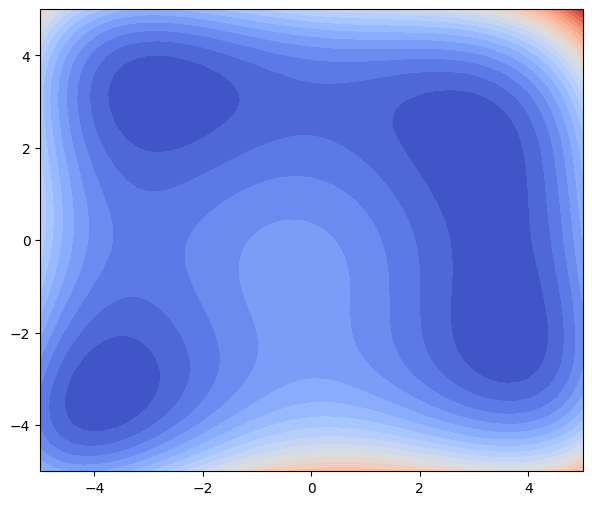

In [19]:
X_x, X_y = np.meshgrid(np.linspace(-5,5,51),np.linspace(-5,5,51))
X = np.vstack((X_x.reshape([1,-1]),X_y.reshape([1,-1])))
z = f(X)

fig, ax = plt.subplots(figsize=(7,6))
ax.contourf(X_x,X_y,z.reshape(X_x.shape), cmap=cm.coolwarm, levels=25, zorder=-1)
fig.canvas.draw()

3. Choose the starting point $x0=(−1.0,0.0)$ and compute the steepest descent direction at that point.

In [20]:
X0 = np.array([-1, 0])
grad_X0 = grad_f(X0[:,None]).squeeze()
hes_X0 = hes_f(X0[:,None]).squeeze()
P0 = -grad_X0
print(f"P0 = {P0}")

P0 = [-24  20]


4. Suppose you are using exact line search solution $α_k^*$ to minimize the function values given in this direction. Find the value of $α_k^*$.  
(Refer class notes example done for quadratic functions)

In [21]:
alpha = np.linspace(0,0.2,100)
phi = lambda alpha: f(X0[:,None] + alpha*P0[:, None])
phi_prime = lambda alpha: grad_f(X0[:,None] + alpha*P0[:, None]).T @ P0[:, None]
phi_taylor = lambda alpha: f(X0[:,None]).squeeze() + alpha*(grad_f(X0[:,None]).squeeze().T @ P0[:, None]) + ((alpha**2)/2)*(grad_f(X0[:,None]).squeeze().T @ hes_f(X0[:, None]).squeeze() @ grad_f(X0[:,None]).squeeze())

e = 0.1

alpha_min = (grad_X0.T @ grad_X0) / (grad_X0.T @ hes_X0 @ grad_X0)
print(f"alpha = {alpha_min}")

alpha = -0.038364779874213835


5. Examin how the function changes its value along the search direction $d_k$. (You may alter the codes given in the example above)  
Can you detect the global minimizer in this direction ?

Global minimizer for alpha = 0.09696969696969697


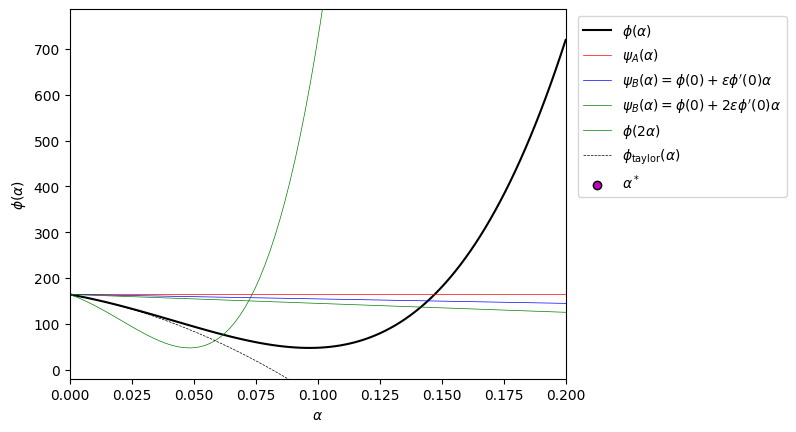

In [22]:
alpha_min_true = alpha[np.argmin(phi(alpha))]

fig, ax = plt.subplots()
ax.plot(alpha, phi(alpha), color="k", linewidth=1.5, linestyle="-",zorder=-1,label=r"$\phi(\alpha)$")
ax.plot(alpha, [phi(0),]*len(alpha), color="r", linewidth=0.5, linestyle="-",label=r"$\psi_A(\alpha)$",zorder=-1)
ax.plot(alpha, phi(0) + e*alpha*phi_prime(0).squeeze(), color="b", linewidth=0.5, linestyle="-",label=r"$\psi_B(\alpha) = \phi(0)+\epsilon\phi'(0)\alpha$",zorder=-1)
ax.plot(alpha, phi(0) + 2*e*alpha*phi_prime(0).squeeze(), color="g", linewidth=0.5, linestyle="-",label=r"$\psi_B(\alpha) = \phi(0)+2\epsilon\phi'(0)\alpha$",zorder=-1)
ax.plot(alpha, phi(2*alpha), color="g", linewidth=0.5, linestyle="-",zorder=-1,label=r"$\phi(2\alpha)$")
ax.plot(alpha, phi_taylor(alpha), color="k", linewidth=0.5, linestyle="--",zorder=-1,label=r"$\phi_\mathrm{taylor}(\alpha)$")
ax.scatter([alpha_min,], [phi(alpha_min),], marker="o", color="m", edgecolors="k", linestyle="None",label=r"$\alpha^*$",zorder=1)
ypad = (max(phi(alpha)) - min(phi(alpha))) * 0.1
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\phi(\alpha)$")
ax.set_xlim((0,0.2))
ax.set_ylim((min(phi(alpha))-ypad,max(phi(alpha))+ypad))
ax.legend(ncol=1,loc='upper left',bbox_to_anchor=(1.01, 1.00))
fig.canvas.draw()

print(f"Global minimizer for alpha = {alpha_min_true}")

6. Compare the values of exact $α$ , true minimum $α$ and the range of α for Armijo conditions described in the above example.

In [23]:
def get_real(roots, last=False):
    reals = [root for root in roots if root.is_real]
    if last:
        return reals[-1]
    else:
        return reals[0]

a = sym.Symbol(r"\alpha", real=True)
x1 = sym.Symbol(r"x_1")
x2 = sym.Symbol(r"x_2")

f_sym = (((x1**2) + x2 - 11)**2) + ((x1 + (x2**2) -7)**2)
display(f_sym)

# try the gradient approach
gradf_sym = sym.Matrix([sym.diff(f_sym,x1),sym.diff(f_sym,x2)])
display(gradf_sym)

# Hessian
Hf_sym = sym.Matrix([[sym.diff(gradf_sym[0],x1),sym.diff(gradf_sym[0],x2)], [sym.diff(gradf_sym[1],x1),sym.diff(gradf_sym[1],x2)]])
display(Hf_sym)

# substitute direction
f_sym = f_sym.subs({x1:X0[0]+P0[0]*a, x2: X0[1]+P0[1]*a})
display(f_sym.simplify())
gradf_sym = gradf_sym.subs({x1:X0[0]+P0[0]*a, x2: X0[1]+P0[1]*a})
display(gradf_sym.applyfunc(simplify))
df_sym=gradf_sym.dot(sym.Matrix([P0[0],P0[1]]))
display(df_sym.simplify())
simplified_df = df_sym.simplify()
coefficients = simplified_df.as_coefficients_dict()

# Convert coefficients to a NumPy array
coeff_array = np.array(list(coefficients.values()))
reversed_arr = coeff_array[::-1]
roots = np.roots(reversed_arr)

# To get the lowest minimum root
def positive_minimum_root(Roots):
    positive_minimum_root = [i for i in Roots if i > 0]
    return positive_minimum_root

print(f"True minimum line search solution = {float(positive_minimum_root(roots)[0])}")

(x_1 + x_2**2 - 7)**2 + (x_1**2 + x_2 - 11)**2

Matrix([
[4*x_1*(x_1**2 + x_2 - 11) + 2*x_1 + 2*x_2**2 - 14],
[ 2*x_1**2 + 4*x_2*(x_1 + x_2**2 - 7) + 2*x_2 - 22]])

Matrix([
[12*x_1**2 + 4*x_2 - 42,          4*x_1 + 4*x_2],
[         4*x_1 + 4*x_2, 4*x_1 + 12*x_2**2 - 26]])

491776*\alpha**4 + 59136*\alpha**3 - 12720*\alpha**2 - 976*\alpha + 164

Matrix([
[-55296*\alpha**3 - 8032*\alpha**2 + 640*\alpha + 24],
[  32000*\alpha**3 - 768*\alpha**2 - 504*\alpha - 20]])

1967104*\alpha**3 + 177408*\alpha**2 - 25440*\alpha - 976

True minimum line search solution = 0.0966751504169573
